<a href="https://colab.research.google.com/github/LennyRBriones/neural-networks-practices/blob/main/Brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
import os
import zipfile

local_zip ="/content/drive/MyDrive/brain_class.zip"
zip_ref = zipfile.ZipFile(local_zip,"r")
zip_ref.extractall("content/drive/MyDrive/brain_class")
zip_ref.close()

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
train_dir = "content/drive/MyDrive/brain_class/Training"
test_dir = "content/drive/MyDrive/brain_class/Testing"

## Data Generators

In [4]:
train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2) # splitting in 20% to validate performance

In [5]:
from tensorflow.python import test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (32, 32),
    batch_size = 12,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset ="training"
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (32, 32),
    batch_size = 12,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "validation"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (32, 32),
    batch_size = 12,
    class_mode = "categorical",
    color_mode = "grayscale",
)

Found 5712 images belonging to 4 classes.
Found 262 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [6]:
classes = ["glioma", "meningioma", "notumor", "pituitary"]

In [7]:
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [8]:
def plotimages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize = (15,15))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img[:,:,0])
    ax.axis("off")
  plt.tight_layout()
  plt.show()

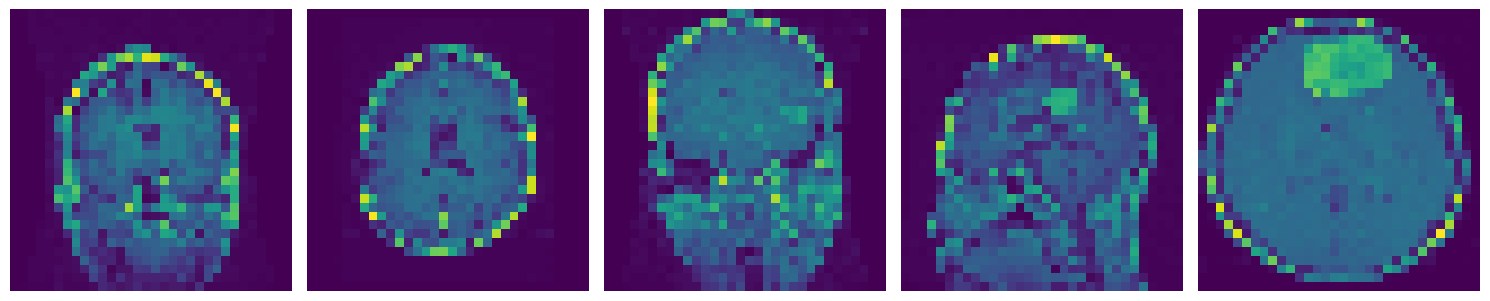

In [9]:
sample_training_images, _ = next(train_generator)
plotimages(sample_training_images[5:10])

## Keras Tuner

In [10]:
from tensorflow.keras import regularizers

In [11]:
! pip install -q -U keras-tuner
import keras_tuner as kt
from tensorflow import keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.5 MB/s eta 0:00:00


In [12]:
def model_constructor(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(20, (3,3), activation ="relu", input_shape = (32,32, 1)))
  model.add(tf.keras.layers.MaxPool2D((2,2)))
  model.add(tf.keras.layers.Flatten())

  #Dynamic generator of neurons
  hp_units = hp.Int("units", min_value = 10, max_value = 80, step = 10)
  model.add(tf.keras.layers.Dense(units = hp_units, activation = "relu", kernel_regularizer = regularizers.l2(1e-5)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(10, activation = "relu", kernel_regularizer= regularizers.l2(1e-5)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(len(classes), activation = "softmax" ))

  hp_learning_rate = hp.Choice("learning_rate", values = [1e-2, 1e-3, 1e-4])

  model.compile(optimizer = keras.optimizers.Adam(learning_rate= hp_learning_rate), loss = "categorical_crossentropy", metrics = ["accuracy"])

  return model

In [13]:
tuner = kt.Hyperband(
    model_constructor,
    objective = "val_accuracy", #to see generalization in new data
    max_epochs=12,
    factor = 3,
    directory = "models/",
    project_name = "brain-lenn-tunner"
)

In [14]:
tuner.search(train_generator, epochs = 12, validation_data = validation_generator)

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
                                          #trials help us to re-test the result

Trial 30 Complete [00h 07m 35s]
val_accuracy: 0.3091602921485901

Best val_accuracy So Far: 0.9351145029067993
Total elapsed time: 01h 20m 41s


In [15]:
print(best_hps.get("units")) #to get the best configuration of neurons

40


In [16]:
print(best_hps.get("learning_rate")) #to get the best configuration of learning rate

0.001


In [17]:
callback_early = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience = 3, mode = "auto") #it could be min or max depends of the metric

In [18]:
hypermodel = tuner.hypermodel.build(best_hps)

history_hypermodel = hypermodel.fit(
    train_generator,
    epochs = 12,
    callbacks = [callback_early],
    validation_data = validation_generator
)

Epoch 1/12
476/476 [==============================] - 39s 79ms/step - loss: 0.9931 - accuracy: 0.5611 - val_loss: 1.0747 - val_accuracy: 0.5840
Epoch 2/12
476/476 [==============================] - 25s 52ms/step - loss: 0.6713 - accuracy: 0.7344 - val_loss: 0.8764 - val_accuracy: 0.6679
Epoch 3/12
476/476 [==============================] - 21s 45ms/step - loss: 0.5954 - accuracy: 0.7586 - val_loss: 0.9035 - val_accuracy: 0.6450
Epoch 4/12
476/476 [==============================] - 24s 51ms/step - loss: 0.5255 - accuracy: 0.8051 - val_loss: 0.6498 - val_accuracy: 0.7176
Epoch 5/12
476/476 [==============================] - 22s 45ms/step - loss: 0.4561 - accuracy: 0.8316 - val_loss: 0.5730 - val_accuracy: 0.7557
Epoch 6/12
476/476 [==============================] - 23s 48ms/step - loss: 0.4231 - accuracy: 0.8465 - val_loss: 0.5589 - val_accuracy: 0.7748
Epoch 7/12
476/476 [==============================] - 22s 47ms/step - loss: 0.3865 - accuracy: 0.8568 - val_loss: 0.6348 - val_accuracy:

In [19]:
# to save the config of the model
config_dict = hypermodel.get_config()

In [20]:
print(config_dict)

{'name': 'sequential_1', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 32, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'conv2d_1_input'}}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 32, 32, 1), 'filters': 20, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_1', 'trainable': True, 'dtype': 'float32', 'pool_size': (2, 2), 'padding': 'valid', 'strides': (2, 2), 'data_format': 'channels_last'}}, 

In [21]:
model_same_config = tf.keras.Sequential.from_config(config_dict)

In [22]:
model_same_config.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 20)        200       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 20)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4500)              0         
                                                                 
 dense_3 (Dense)             (None, 40)                180040    
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                410       
                                                      

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [24]:
def get_model():
   model = tf.keras.models.Sequential([
             tf.keras.layers.Conv2D(20, (3,3), activation = "relu", input_shape = (32, 32,1)),
             tf.keras.layers.MaxPool2D((2,2)),
             tf.keras.layers.Flatten(),
             tf.keras.layers.Dense(40, kernel_regularizer= regularizers.l2(0.001), activation = "relu"),
             tf.keras.layers.Dropout(0.2),
             tf.keras.layers.Dense(10, kernel_regularizer= regularizers.l2(0.001), activation = "relu"),
             tf.keras.layers.Dropout(0.2),
             tf.keras.layers.Dense(len(classes), activation ="softmax")
   ])
   return model

model_early =  get_model()
model_early.summary()

model_early.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 20)        200       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 20)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4500)              0         
                                                                 
 dense_6 (Dense)             (None, 40)                180040    
                                                                 
 dropout_4 (Dropout)         (None, 40)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                410       
                                                      

In [25]:
model_weight = get_model()
model_weight.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 20)        200       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 20)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4500)              0         
                                                                 
 dense_9 (Dense)             (None, 40)                180040    
                                                                 
 dropout_6 (Dropout)         (None, 40)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                410       
                                                      

In [26]:
model_weight.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [27]:
checkpoint_path = "model_checkpoints/checkpoint"
checkpoint_weights = ModelCheckpoint(
    filepath = checkpoint_path,
    frecuency = "epoch",
    save_weights_only = True,
    verbose = 1 #show us information during training
)

In [42]:
history_weigth = model_weight.fit(
    train_generator,
    epochs = 20,
    callbacks = [checkpoint_weights],
    validation_data = validation_generator
)

Epoch 1/20
476/476 [==============================] - ETA: 0s - loss: 0.4131 - accuracy: 0.8948
Epoch 1: val_accuracy did not improve from 0.88550
476/476 [==============================] - 30s 63ms/step - loss: 0.4131 - accuracy: 0.8948 - val_loss: 0.5106 - val_accuracy: 0.8626
Epoch 2/20
475/476 [============================>.] - ETA: 0s - loss: 0.3997 - accuracy: 0.8984
Epoch 2: val_accuracy improved from 0.88550 to 0.88931, saving model to model_checkpoints_complete


476/476 [==============================] - 25s 52ms/step - loss: 0.3993 - accuracy: 0.8986 - val_loss: 0.4696 - val_accuracy: 0.8893
Epoch 3/20
476/476 [==============================] - ETA: 0s - loss: 0.3959 - accuracy: 0.9035
Epoch 3: val_accuracy did not improve from 0.88931
476/476 [==============================] - 27s 57ms/step - loss: 0.3959 - accuracy: 0.9035 - val_loss: 0.4477 - val_accuracy: 0.8626
Epoch 4/20
475/476 [============================>.] - ETA: 0s - loss: 0.3669 - accuracy: 0.9111
Epoch 4: val_accuracy did not improve from 0.88931
476/476 [==============================] - 22s 46ms/step - loss: 0.3667 - accuracy: 0.9111 - val_loss: 0.4514 - val_accuracy: 0.8855
Epoch 5/20
476/476 [==============================] - ETA: 0s - loss: 0.3710 - accuracy: 0.9111
Epoch 5: val_accuracy did not improve from 0.88931
476/476 [==============================] - 22s 46ms/step - loss: 0.3710 - accuracy: 0.9111 - val_loss: 0.4477 - val_accuracy: 0.8817
Epoch 6/20
476/476 [=======

476/476 [==============================] - 26s 55ms/step - loss: 0.3757 - accuracy: 0.9119 - val_loss: 0.4569 - val_accuracy: 0.8931
Epoch 7/20
476/476 [==============================] - ETA: 0s - loss: 0.3710 - accuracy: 0.9107
Epoch 7: val_accuracy improved from 0.89313 to 0.92748, saving model to model_checkpoints_complete


476/476 [==============================] - 22s 47ms/step - loss: 0.3710 - accuracy: 0.9107 - val_loss: 0.3592 - val_accuracy: 0.9275
Epoch 8/20
475/476 [============================>.] - ETA: 0s - loss: 0.3564 - accuracy: 0.9207
Epoch 8: val_accuracy improved from 0.92748 to 0.93893, saving model to model_checkpoints_complete


476/476 [==============================] - 25s 53ms/step - loss: 0.3568 - accuracy: 0.9207 - val_loss: 0.3489 - val_accuracy: 0.9389
Epoch 9/20
476/476 [==============================] - ETA: 0s - loss: 0.3474 - accuracy: 0.9219
Epoch 9: val_accuracy did not improve from 0.93893
476/476 [==============================] - 23s 49ms/step - loss: 0.3474 - accuracy: 0.9219 - val_loss: 0.5379 - val_accuracy: 0.8511
Epoch 10/20
476/476 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.9261
Epoch 10: val_accuracy did not improve from 0.93893
476/476 [==============================] - 22s 46ms/step - loss: 0.3377 - accuracy: 0.9261 - val_loss: 0.3427 - val_accuracy: 0.9237
Epoch 11/20
476/476 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.9207
Epoch 11: val_accuracy did not improve from 0.93893
476/476 [==============================] - 22s 46ms/step - loss: 0.3532 - accuracy: 0.9207 - val_loss: 0.4172 - val_accuracy: 0.9046
Epoch 12/20
476/476 [==

##Saving Model Weigths

In [43]:
checkpoint_path = "model_checkpoints_complete" #because we want to save all
checkpoint_weights = ModelCheckpoint(
    filepath = checkpoint_path,
    frecuency = "epoch",
    save_weights_only = False, #this because we want to save model and wights
    monitor = "val_accuracy", #to save only the best model
    save_best_only = True,
    verbose = 1 #show us information during training
)

In [44]:
model_complete = get_model()
model_complete.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

history_complete = model_complete.fit(
    train_generator,
    epochs = 20,
    callbacks = [checkpoint_weights],
    validation_data = validation_generator
)

Epoch 1/20
475/476 [============================>.] - ETA: 0s - loss: 0.9547 - accuracy: 0.6153
Epoch 1: val_accuracy improved from -inf to 0.66412, saving model to model_checkpoints_complete


476/476 [==============================] - 25s 50ms/step - loss: 0.9541 - accuracy: 0.6155 - val_loss: 0.8754 - val_accuracy: 0.6641
Epoch 2/20
475/476 [============================>.] - ETA: 0s - loss: 0.7040 - accuracy: 0.7546
Epoch 2: val_accuracy improved from 0.66412 to 0.72137, saving model to model_checkpoints_complete


476/476 [==============================] - 23s 48ms/step - loss: 0.7035 - accuracy: 0.7546 - val_loss: 0.8073 - val_accuracy: 0.7214
Epoch 3/20
475/476 [============================>.] - ETA: 0s - loss: 0.6120 - accuracy: 0.7968
Epoch 3: val_accuracy improved from 0.72137 to 0.72901, saving model to model_checkpoints_complete


476/476 [==============================] - 24s 51ms/step - loss: 0.6124 - accuracy: 0.7966 - val_loss: 0.7054 - val_accuracy: 0.7290
Epoch 4/20
476/476 [==============================] - ETA: 0s - loss: 0.5671 - accuracy: 0.8260
Epoch 4: val_accuracy improved from 0.72901 to 0.80534, saving model to model_checkpoints_complete


476/476 [==============================] - 24s 50ms/step - loss: 0.5671 - accuracy: 0.8260 - val_loss: 0.6160 - val_accuracy: 0.8053
Epoch 5/20
475/476 [============================>.] - ETA: 0s - loss: 0.5265 - accuracy: 0.8416
Epoch 5: val_accuracy did not improve from 0.80534
476/476 [==============================] - 22s 46ms/step - loss: 0.5259 - accuracy: 0.8419 - val_loss: 0.6470 - val_accuracy: 0.7710
Epoch 6/20
476/476 [==============================] - ETA: 0s - loss: 0.5087 - accuracy: 0.8547
Epoch 6: val_accuracy did not improve from 0.80534
476/476 [==============================] - 22s 45ms/step - loss: 0.5087 - accuracy: 0.8547 - val_loss: 0.5573 - val_accuracy: 0.7786
Epoch 7/20
475/476 [============================>.] - ETA: 0s - loss: 0.4967 - accuracy: 0.8614
Epoch 7: val_accuracy did not improve from 0.80534
476/476 [==============================] - 23s 49ms/step - loss: 0.4967 - accuracy: 0.8615 - val_loss: 0.6198 - val_accuracy: 0.7786
Epoch 8/20
476/476 [=======

476/476 [==============================] - 25s 52ms/step - loss: 0.4702 - accuracy: 0.8715 - val_loss: 0.4995 - val_accuracy: 0.8359
Epoch 9/20
476/476 [==============================] - ETA: 0s - loss: 0.4364 - accuracy: 0.8836
Epoch 9: val_accuracy did not improve from 0.83588
476/476 [==============================] - 23s 49ms/step - loss: 0.4364 - accuracy: 0.8836 - val_loss: 0.5459 - val_accuracy: 0.8015
Epoch 10/20
476/476 [==============================] - ETA: 0s - loss: 0.4319 - accuracy: 0.8850
Epoch 10: val_accuracy improved from 0.83588 to 0.84351, saving model to model_checkpoints_complete


476/476 [==============================] - 25s 52ms/step - loss: 0.4319 - accuracy: 0.8850 - val_loss: 0.5735 - val_accuracy: 0.8435
Epoch 11/20
476/476 [==============================] - ETA: 0s - loss: 0.4312 - accuracy: 0.8857
Epoch 11: val_accuracy did not improve from 0.84351
476/476 [==============================] - 22s 46ms/step - loss: 0.4312 - accuracy: 0.8857 - val_loss: 0.4963 - val_accuracy: 0.8130
Epoch 12/20
476/476 [==============================] - ETA: 0s - loss: 0.4041 - accuracy: 0.8992
Epoch 12: val_accuracy did not improve from 0.84351
476/476 [==============================] - 23s 49ms/step - loss: 0.4041 - accuracy: 0.8992 - val_loss: 0.5507 - val_accuracy: 0.8130
Epoch 13/20
476/476 [==============================] - ETA: 0s - loss: 0.3898 - accuracy: 0.9107
Epoch 13: val_accuracy improved from 0.84351 to 0.85115, saving model to model_checkpoints_complete


476/476 [==============================] - 24s 51ms/step - loss: 0.3898 - accuracy: 0.9107 - val_loss: 0.4501 - val_accuracy: 0.8511
Epoch 14/20
475/476 [============================>.] - ETA: 0s - loss: 0.3823 - accuracy: 0.9095
Epoch 14: val_accuracy improved from 0.85115 to 0.85878, saving model to model_checkpoints_complete


476/476 [==============================] - 23s 49ms/step - loss: 0.3829 - accuracy: 0.9091 - val_loss: 0.4732 - val_accuracy: 0.8588
Epoch 15/20
475/476 [============================>.] - ETA: 0s - loss: 0.3890 - accuracy: 0.9061
Epoch 15: val_accuracy did not improve from 0.85878
476/476 [==============================] - 23s 49ms/step - loss: 0.3886 - accuracy: 0.9063 - val_loss: 0.4576 - val_accuracy: 0.8588
Epoch 16/20
476/476 [==============================] - ETA: 0s - loss: 0.3807 - accuracy: 0.9146
Epoch 16: val_accuracy improved from 0.85878 to 0.88550, saving model to model_checkpoints_complete


476/476 [==============================] - 25s 53ms/step - loss: 0.3807 - accuracy: 0.9146 - val_loss: 0.4318 - val_accuracy: 0.8855
Epoch 17/20
475/476 [============================>.] - ETA: 0s - loss: 0.3607 - accuracy: 0.9184
Epoch 17: val_accuracy improved from 0.88550 to 0.90840, saving model to model_checkpoints_complete


476/476 [==============================] - 23s 49ms/step - loss: 0.3612 - accuracy: 0.9182 - val_loss: 0.3955 - val_accuracy: 0.9084
Epoch 18/20
476/476 [==============================] - ETA: 0s - loss: 0.3645 - accuracy: 0.9184
Epoch 18: val_accuracy did not improve from 0.90840
476/476 [==============================] - 23s 48ms/step - loss: 0.3645 - accuracy: 0.9184 - val_loss: 0.4622 - val_accuracy: 0.8664
Epoch 19/20
475/476 [============================>.] - ETA: 0s - loss: 0.3458 - accuracy: 0.9233
Epoch 19: val_accuracy did not improve from 0.90840
476/476 [==============================] - 23s 49ms/step - loss: 0.3459 - accuracy: 0.9233 - val_loss: 0.4176 - val_accuracy: 0.8969
Epoch 20/20
475/476 [============================>.] - ETA: 0s - loss: 0.3506 - accuracy: 0.9251
Epoch 20: val_accuracy improved from 0.90840 to 0.92366, saving model to model_checkpoints_complete


476/476 [==============================] - 25s 52ms/step - loss: 0.3509 - accuracy: 0.9251 - val_loss: 0.3765 - val_accuracy: 0.9237


### Saving in a ZIP

In [45]:
!zip model_checkpoints_complete *

updating: content/ (stored 0%)
updating: drive/ (stored 0%)
updating: model_checkpoints/ (stored 0%)
updating: model_checkpoints_complete/ (stored 0%)
updating: models/ (stored 0%)
updating: sample_data/ (stored 0%)
  adding: brain_model.h5 (deflated 9%)
  adding: save_model_complete/ (stored 0%)


### Saving in H5py

In [46]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
model_complete.save("save_model_complete/mymodel")

In [49]:
model_completenew = tf.keras.models.load_model("save_model_complete/mymodel") 

In [50]:
model_completenew.evaluate(test_generator)

110/110 [==============================] - 4s 38ms/step - loss: 0.4182 - accuracy: 0.8947


[0.41820916533470154, 0.8947368264198303]

In [51]:
model_complete.evaluate(test_generator)

110/110 [==============================] - 3s 30ms/step - loss: 0.4182 - accuracy: 0.8947


[0.4182092249393463, 0.8947368264198303]

In [52]:
model_completenew.save("brain_model.h5")

In [53]:
model_completenew2 = tf.keras.models.load_model("brain_model.h5")

In [54]:
model_completenew2.evaluate(test_generator)

110/110 [==============================] - 3s 30ms/step - loss: 0.4182 - accuracy: 0.8947


[0.4182092249393463, 0.8947368264198303]